In [1]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("data/RickAndMortyScripts.csv")
df.head()

,index,season no.,episode no.,episode name,name,line
0,0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."


In [2]:
df.describe()

,index,season no.,episode no.
count,1905.000000,1905.000000,1905.000000
mean,1190.003675,2.155381,3.208399
std,721.719735,0.832004,2.247812
min,0.000000,1.000000,1.000000
25%,548.000000,1.000000,1.000000
50%,1164.000000,2.000000,3.000000
75%,1844.000000,3.000000,5.000000
max,2487.000000,3.000000,10.000000


In [3]:
df.nunique()

index           1905
season no.         3
episode no.        9
episode name      11
name              48
line            1860
dtype: int64

In [4]:
df.count()

index           1905
season no.      1905
episode no.     1905
episode name    1905
name            1905
line            1905
dtype: int64

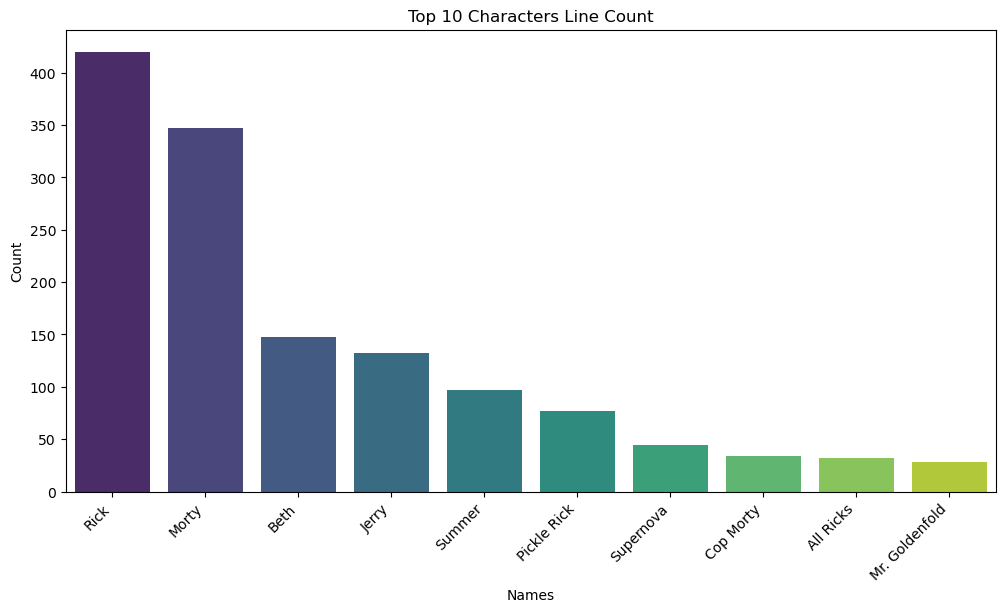

In [5]:
top_names = df['name'].value_counts().nlargest(10).index

filtered_data = df[df['name'].isin(top_names)]

plt.figure(figsize=(12, 6))  
ax = sns.countplot(data=filtered_data, x='name', order=top_names, palette='viridis')

ax.set(xlabel='Names', ylabel='Count', title='Top 10 Characters Line Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [6]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

sw = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in sw])

def apply_re(df, column):
    tokenizer = TweetTokenizer()
    transformed_column = 'normalized'
    df[transformed_column] = df[column]
    df[transformed_column] = df[transformed_column].apply(lambda text: remove_stopwords(text))
    df[transformed_column] = df[transformed_column].apply(lambda text: contractions.fix(text))
    df[transformed_column] = df[transformed_column].str.lower()
    df[transformed_column] = df[transformed_column].str.replace(r"http\S+", " ", regex=True)
    df[transformed_column] = df[transformed_column].str.replace(r'\d+', '')
    df[transformed_column] = df[transformed_column].str.replace('[^A-Za-z0-9]+', ' ', regex=True)
    df[transformed_column] = df[transformed_column].apply(lambda text: ' '.join(tokenizer.tokenize(text)))
    df[transformed_column] = df[transformed_column].apply(lambda text: remove_stopwords(text))
    df[transformed_column] = df[transformed_column].str.strip()
    return df

transformed_column = 'normalized'
df = apply_re(df,'line')
df[transformed_column].head(10)

0                          morty got come jus got come
1                                           rick going
2                                   got surprise morty
3                                 middle night talking
4                         come got surprise come hurry
5                                   ow ow tugging hard
6         got go got get outta come got surprise morty
7    think flying vehicle morty built outta stuff f...
8                             yeah rick great surprise
9                    morty make bomb morty create bomb
Name: normalized, dtype: object

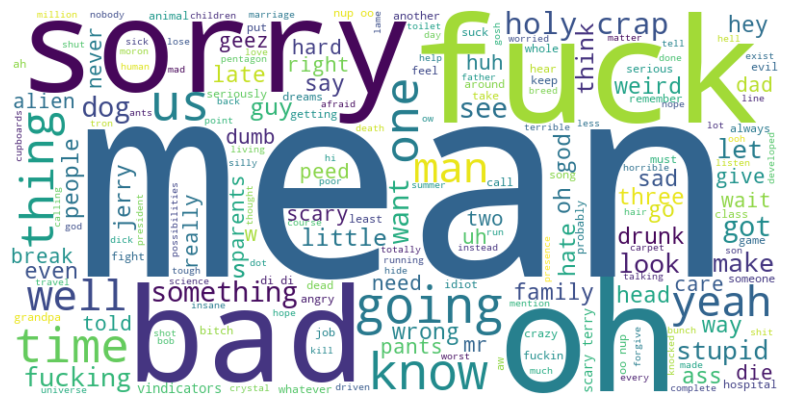

In [7]:
import nltk
from nltk import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
import re
df[transformed_column] = df[transformed_column].astype(str) 
                                                                                                                             
tokenizer = TweetTokenizer()
df['tokens'] = df[transformed_column].apply(lambda text: tokenizer.tokenize(text))

df['sentiment'] = df[transformed_column].apply(lambda text: TextBlob(text).sentiment.polarity)

negative_lines = df[df['sentiment'] < -0.2][transformed_column]

negative_text = ' '.join(negative_lines)

exclude_words = ['rick', 'morty']
for word in exclude_words:
    negative_text = negative_text.replace(word, '')

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

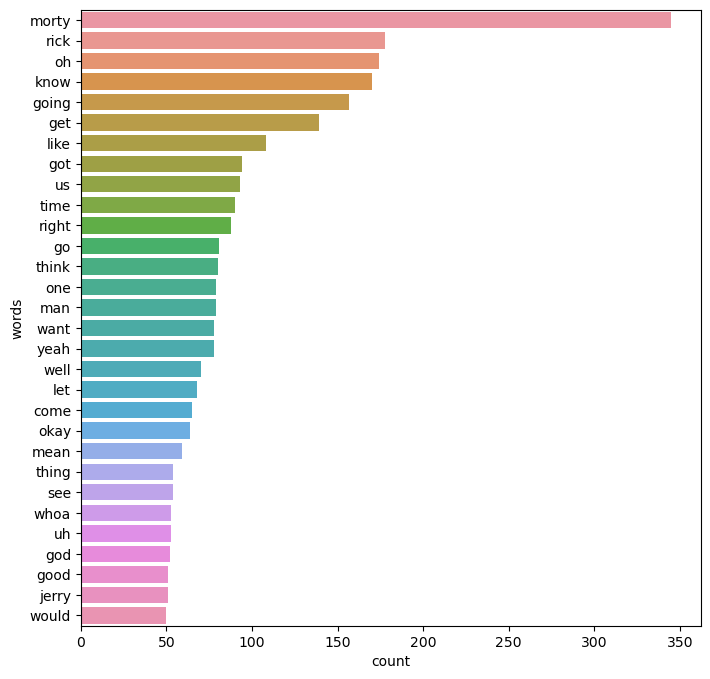

In [8]:
import itertools
import collections
lem_list = list(df['tokens'])
token_list = list(itertools.chain(*lem_list))
counts = collections.Counter(token_list)
clean_df = pd.DataFrame(counts.most_common(30), columns=['words','count'])
clean_df_sorted = clean_df.sort_values(by='count', ascending=False)

fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x='count', y='words', data=clean_df_sorted, ax=ax)
plt.show()

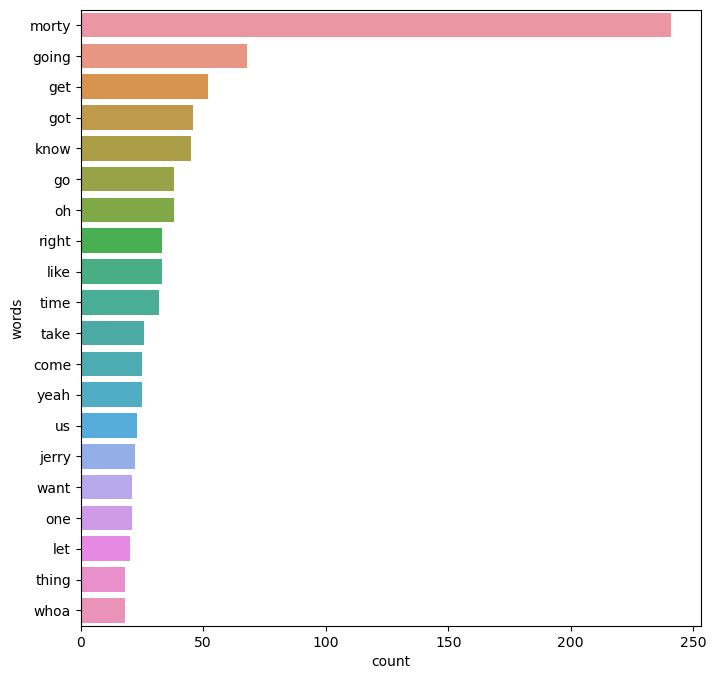

In [9]:
rick_df = df[df['name'] == 'Rick']
lem_list = list(rick_df['tokens'])
token_list = list(itertools.chain(*lem_list))
counts = collections.Counter(token_list)

clean_df = pd.DataFrame(counts.most_common(20), columns=['words', 'count']).sort_values(by='count', ascending=False)

fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x='count', y='words', data=clean_df, ax=ax)
plt.show()

In [10]:
#doing average mood by characters
from nrclex import NRCLex
 
for name in top_names:
    # Get the lines associated with the current name
    lines = df[df['name'] == name]['line']

    # Initialize an empty dictionary to store emotion scores
    total_emotion_scores = {}

    # Loop through each line for the current name
    for line in lines:
        # Analyze the emotion for the current line
        emotion = NRCLex(line)
        
        # Aggregate emotion scores for each line
        for e, score in emotion.raw_emotion_scores.items():
            if e in total_emotion_scores:
                total_emotion_scores[e] += score
            else:
                total_emotion_scores[e] = score

    # Find the most dominant emotion for the current name
    most_dominant_emotion = max(total_emotion_scores, key=total_emotion_scores.get)

    # Print the result
    print(f'{name}: Most dominant emotion - {most_dominant_emotion} ({total_emotion_scores[most_dominant_emotion]})')

Rick: Most dominant emotion - negative (235)
Morty: Most dominant emotion - negative (106)
Beth: Most dominant emotion - positive (65)
Jerry: Most dominant emotion - positive (72)
Summer: Most dominant emotion - positive (36)
Pickle Rick: Most dominant emotion - negative (39)
Supernova: Most dominant emotion - positive (18)
Cop Morty: Most dominant emotion - positive (11)
All Ricks: Most dominant emotion - negative (36)
Mr. Goldenfold: Most dominant emotion - positive (17)


In [11]:
result_data = []
for name in top_names:
    
    lines = df[df['name'] == name]['line']

    total_emotion_scores = {}

    for line in lines:
        emotion = NRCLex(line)
        
        for e, score in emotion.raw_emotion_scores.items():
            if e in total_emotion_scores:
                total_emotion_scores[e] += score
            else:
                total_emotion_scores[e] = score

    top_emotions = sorted(total_emotion_scores, key=total_emotion_scores.get, reverse=True)[:6]

#     print(f'{name}: Top 6 emotions - {", ".join([f"{e} ({total_emotion_scores[e]})" for e in top_emotions])}')
    result_dict = {'name': name}
    
    result_dict = {'name': name}
    for emotion, score in total_emotion_scores.items():
        result_dict[emotion] = score

    result_data.append(result_dict)


result_df = pd.DataFrame(result_data)

result_df

,name,fear,joy,positive,surprise,anticipation,trust,anger,negative,sadness,disgust
0,Rick,140,106,231,74,147,142,97,235,108,80
1,Morty,73,42,71,31,41,46,52,106,48,40
2,Beth,31,29,65,17,30,55,22,52,34,17
3,Jerry,21,43,72,15,36,39,23,48,21,15
4,Summer,20,17,36,7,22,27,19,36,14,18
5,Pickle Rick,18,18,38,8,15,14,14,39,15,13
6,Supernova,6,11,18,4,15,15,4,9,5,2
7,Cop Morty,9,3,11,2,6,7,4,11,7,2
8,All Ricks,20,7,21,7,27,8,14,36,18,12
9,Mr. Goldenfold,6,10,17,4,9,14,7,11,7,6


In [12]:
from math import pi

emotions_to_drop = ['positive','negative']
cleaned_df = result_df.iloc[:5, :]
cleaned_df.drop(emotions_to_drop, axis=1, inplace=True)
cleaned_df

,name,fear,joy,surprise,anticipation,trust,anger,sadness,disgust
0,Rick,140,106,74,147,142,97,108,80
1,Morty,73,42,31,41,46,52,48,40
2,Beth,31,29,17,30,55,22,34,17
3,Jerry,21,43,15,36,39,23,21,15
4,Summer,20,17,7,22,27,19,14,18


In [13]:
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
df = cleaned_df
fig = go.Figure()

for index, row in df.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[1:],
        theta=df.columns[1:],
        fill='toself',
        name=row['name']
    ))

fig.update_layout(
    title=go.layout.Title(text='Emotion Comparison'),
    polar={'radialaxis': {'visible': True}},
    showlegend=True
)

iplot(fig)